# Objectives

1. Plot Locus Coverage of Whole Genome.
1. Add Locus Coverage to Dataframe.
1. Plot Locus Coverage: Distribution.
1. Plot Locus Coverage: Phlyo.
1. Identify Interesting Samples.

---
# Setup

## Imports

In [5]:
import os
import subprocess
from Bio import Phylo
import copy
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import lines, patches, colors, gridspec, ticker
import seaborn as sns
import scipy.stats
from functions import *

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import numpy as np


## Variables

In [6]:
#WILDCARDS = ["all", "chromosome", "full", "30"]
WILDCARDS = ["sra", "chromosome", "full", "5"]
#project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/denmark/"
project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/pla/"
results_dir = project_dir

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

NO_DATA_CHAR = "NA"

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)

plt.rcParams['lines.linewidth'] = 0.5

flierprops = dict(marker='o', markerfacecolor='black', markersize=1,
                   markeredgecolor='none')

D3_COL_PAL = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

## Paths

In [7]:
colors_path = os.path.join(
    results_dir,
    "augur/{}/{}/{}/filter{}/beast/colors.tsv"
    .format(READS_ORIGIN, LOCUS_NAME, PRUNE, MISSING_DATA)
)

tree_path = os.path.join(
    results_dir, 
    "augur/{}/{}/{}/filter{}/beast/all.timetree.nwk"
    .format(READS_ORIGIN, LOCUS_NAME, PRUNE, MISSING_DATA)
)
"""metadata_path = os.path.join(
    results_dir, 
    "augur/{}/{}/{}/filter{}/beast/metadata.tsv"
    .format(READS_ORIGIN, LOCUS_NAME, PRUNE, MISSING_DATA)
)"""
metadata_path = os.path.join(results_dir, "metadata/all/metadata.tsv"
)

cov_df_path = os.path.join(
    results_dir, 
    "locus_coverage_collect/{}/locus_coverage.txt"
    .format(READS_ORIGIN)
)

dep_df_path = os.path.join(
    results_dir, 
    "locus_coverage_collect/{}/locus_depth.txt"
    .format(READS_ORIGIN)
)
ref_gff_path = os.path.join(
    results_dir,
    "data/reference/GCA_000009065.1_ASM906v1_genomic/GCA_000009065.1_ASM906v1_genomic.gff"
)

# ------------------------------------------
# Output
out_dir = os.path.join(results_dir, "locus_coverage_collect/{}/".format(READS_ORIGIN))
print(out_dir)

/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/pla/locus_coverage_collect/sra/


## Import Tree

In [8]:
"""tree = Phylo.read(tree_path, format="newick")
tree.ladderize(reverse=True)"""

'tree = Phylo.read(tree_path, format="newick")\ntree.ladderize(reverse=True)'

## Import Metadata

In [9]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
metadata_df.set_index(metadata_df.columns[0], inplace=True)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

#display(metadata_df)

## Import Locus Dataframes

In [10]:
cov_df = pd.read_csv(cov_df_path, sep='\t')
cov_df.set_index("Sample", inplace=True)

#display(cov_df)  

dep_df = pd.read_csv(dep_df_path, sep='\t')
dep_df.set_index("Sample", inplace=True)
               
#display(dep_df)

In [11]:
# Remove samples not in tree dataframe (ex. outgroup)
for sample in cov_df.index:
    if sample not in metadata_df.index:
        print("Dropping:",sample)
        cov_df.drop(sample, inplace=True)
        dep_df.drop(sample, inplace=True)

# exception

#sample = "SAMN01991268"
#if sample in metadata_df.index:
#    cov_df.drop(sample, inplace=True)
#    dep_df.drop(sample, inplace=True)    

## Import Reference GFF

In [12]:
ref_gff_columns = [
        "seqname",
        "source",
        "feature",
        "start", #sequence numbering starting at 1.
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
        "id",
]

ref_gff_tsv = ref_gff_path + ".tsv"
subprocess.run(["rm", "-f", ref_gff_tsv]) 

with open(ref_gff_path) as infile:
    with open(ref_gff_tsv, "a") as outfile:
        ref_gff_read = infile.read().split("\n")
        for line in ref_gff_read:
            if not line.startswith("#"):
                split_line = line.strip().split("\t")
                attr = split_line[-1].split(";")
                attr_id = attr[0].split("=")
                if len(attr_id) < 2:
                    continue
                attr_id = attr_id[1]
                line += "\t{}".format(attr_id)
                outfile.write(line + "\n")
                
ref_df = pd.read_csv(ref_gff_tsv, sep='\t', header=None)
ref_df.columns = ref_gff_columns
ref_df.set_index("id", inplace=True)
#display(ref_df)

## Create Dataframes for replicons and genes

In [13]:
ref_rep_df = ref_df[ref_df["feature"] == "region"]
#display(ref_rep_df)

ref_gene_df = ref_df[ref_df["feature"] == "gene"]
#display(ref_gene_df)

## Separate Dataframe by Type

In [14]:
cov_rep_df = copy.deepcopy(cov_df)
cov_gene_df = copy.deepcopy(cov_df)
dep_rep_df = copy.deepcopy(dep_df)
dep_gene_df = copy.deepcopy(dep_df)
non_replicon_loci = []
non_gene_loci = []

for col in cov_df.columns:
    if col not in ref_rep_df.index:
        non_replicon_loci.append(col)
    if col not in ref_gene_df.index:
        non_gene_loci.append(col)
        
cov_rep_df.drop(columns=non_replicon_loci, inplace=True)
display(cov_rep_df)

dep_rep_df.drop(columns=non_replicon_loci, inplace=True)
#display(dep_rep_df)
       
cov_gene_df.drop(columns=non_gene_loci, inplace=True)
#display(cov_gene_df)

dep_gene_df.drop(columns=non_gene_loci, inplace=True)
#display(dep_gene_df)

,AL590842.1:1..4653728,AL117189.1:1..70305,AL117211.1:1..96210,AL109969.1:1..9612
Sample,,,,
SAMN01853158,0.954767,0.944655,0.942937,0.814711
SAMN01853157,0.955531,0.944726,0.944039,0.815231
SAMN01853130,0.931089,0.948098,0.944673,0.814607
SAMN01853159,0.932010,0.928099,0.859775,0.805764
SAMN01991273,0.955264,0.944115,0.943343,0.803787
SAMN01991272,0.955530,0.942892,0.943634,0.803683
SAMN01991271,0.954097,0.946746,0.943322,0.803891
SAMN01991270,0.955996,0.945850,0.943259,0.803891
SAMN01991269,0.956122,0.943973,0.943395,0.803683


---
# pPCP1 Analysis

In [15]:
target_seqname = "AL109969"
target_locus = "AL109969.1:1..9612" # pPCP1
target_gene = "gene-YPPCP1.07" # pla
# Exclude IS100 and the IS100 transposase
exclude_samples = ["P187","P212","P387",]
exclude_genes = ["gene-YPPCP1.01", "gene-YPPCP1.02" ]
gene_labels = {
    "gene-YPPCP1.01": 
        {
            "label": "IS100",
            "coord": [87, 1109],
            "color" : "#c4c4c4",
        },
    "gene-YPPCP1.02": 
        {
            "label": "IS100",
            "coord": [1106, 1888],
            "color" : "#c4c4c4",            
        },
    "gene-YPPCP1.03": 
        {
            "label": "rop",
            "coord": [2925, 3119],
            "color": "#1f77b4",
        },    
    "gene-YPPCP1.04": 
        {
            "label": "pim",
            "coord": [4355, 4780],
            "color": "#1f77b4",            
        },  
    "gene-YPPCP1.05c": 
        {
            "label": "pst",
             "coord": [4815, 5888],
            "color": "#1f77b4",            
        }, 
    "gene-YPPCP1.06": 
        {
            "label": "Hypothetical protein",
            "coord": [6006, 6422],
            "color": "#1f77b4",            
        },     
    "gene-YPPCP1.07": 
        {
            "label": "pla",
            "coord": [6665, 7603],
            "color" : "#ff7f0e",
        }, 
    "gene-YPPCP1.08c": 
        {
            "label": "Probable transcriptional regulator",
            "coord": [7790, 8089],
            "color" : "#ff7f0e",            
        }, 
    "gene-YPPCP1.09c": 
        {
            "label": "Hypothetical protein",
            "coord": [8089, 8436],
            "color" : "#ff7f0e",            
        },    
}

In [16]:
# Select the plasmid genes from the reference
ppcp1_genes = list(ref_gene_df[ref_gene_df["seqname"] == target_seqname].index)

# Select the depth
ppcp1_genes_df = dep_gene_df[ppcp1_genes]

display(ppcp1_genes_df)

,gene-YPPCP1.01,gene-YPPCP1.02,gene-YPPCP1.03,gene-YPPCP1.04,gene-YPPCP1.05c,gene-YPPCP1.06,gene-YPPCP1.07,gene-YPPCP1.08c,gene-YPPCP1.09c
Sample,,,,,,,,,
SAMN01853158,0.0,3.716475,230.579483,244.530518,240.716019,236.163071,242.989349,237.703339,237.649429
SAMN01853157,0.0,8.513410,283.610260,307.084503,298.711365,288.199036,303.004273,297.803345,291.784485
SAMN01853130,0.0,6.670498,288.184601,285.845062,288.465546,279.211029,291.855164,292.266663,284.692535
SAMN01853159,0.0,0.586207,199.748718,199.732391,199.348236,199.422058,199.514374,199.253326,199.103455
SAMN01991273,0.0,0.002554,74.512817,77.422539,75.919922,67.163071,76.784874,80.023331,70.155174
SAMN01991272,0.0,0.002554,83.400002,81.708923,75.935753,70.928055,80.829605,81.313332,78.071838
SAMN01991271,0.0,0.003831,85.133331,87.849762,82.640594,78.462830,83.086266,87.906670,81.836205
SAMN01991270,0.0,0.005109,83.764099,85.464790,81.671326,75.270981,78.703941,88.223335,80.356323
SAMN01991269,0.0,0.005109,91.502564,95.122063,90.467415,84.546761,93.839188,98.573334,90.867813


---
## Calculate Depletion Ratio

In [34]:
# Gene ID
depleted_gene = "gene-YPPCP1.07" # pla
baseline_gene = "gene-YPPCP1.05c" #pst

# Gene Label
depleted_gene_label = gene_labels[depleted_gene]["label"]
baseline_gene_label = gene_labels[baseline_gene]["label"]

# Gene Depth
baseline_dep = list(ppcp1_genes_df[baseline_gene])
depleted_dep = list(ppcp1_genes_df[depleted_gene])

# Accessory plotting variables
sample = list(ppcp1_genes_df.index)
#timetree_num_date = metadata_df["timetree_num_date"][ppcp1_genes_df.index]
timetree_num_date = metadata_df["date_mean"][ppcp1_genes_df.index]
strain = metadata_df["strain"][ppcp1_genes_df.index]
#root_rtt_dist = metadata_df["root_rtt_dist"][ppcp1_genes_df.index]
country = metadata_df["country"][ppcp1_genes_df.index]
ratio = []
for depleted,baseline in zip(depleted_dep, baseline_dep):
    if baseline == 0:
        ratio.append(0)
    else:
        ratio.append(depleted/baseline)

data = {
    "baseline": baseline_dep, 
    "depleted": depleted_dep, 
    "ratio": ratio, 
    "sample" : sample,
    "timetree_num_date": timetree_num_date,
    "strain" : strain,
    "country" : country,
    #"root_rtt_dist" : root_rtt_dist,
    }

ratio_df = pd.DataFrame(data)
ratio_df.set_index("sample", inplace=True)
ratio_df.sort_values(by="ratio", inplace=True)
#ratio_df.sort_values(by="baseline", inplace=True)

display(ratio_df)

,baseline,depleted,ratio,timetree_num_date,strain,country
sample,,,,,,
SAMN05731684,447.500946,410.294983,0.916858,2009.0,Yp3043,Madagascar
SAMN05731694,475.796082,436.598511,0.917617,2009.0,Yp3041,Madagascar
SAMN05731688,520.079163,487.576141,0.937504,2004.0,Yp2905,Madagascar
SAMN05731702,586.903137,556.829590,0.948759,2010.0,Yp3050,Madagascar
SAMN05731707,316.441345,300.345062,0.949133,2009.0,Yp3045,Madagascar
SAMN15503562,692.042847,659.314148,0.952707,2014.0,13/14,Madagascar
SAMN05731703,434.110809,414.203400,0.954142,2011.0,Yp3059,Madagascar
SAMN05731698,425.077270,405.677307,0.954361,2008.0,Yp3034,Madagascar
SAMN05731679,374.102417,357.662415,0.956055,2008.0,Yp3026,Madagascar


## Filter Genomes

In [35]:
# Keep only high cov samples
ppcp1_genes_orig_df = copy.deepcopy(ppcp1_genes_df)
ratio_orig_df = copy.deepcopy(ratio_df)


high_cov_samples = list(dep_rep_df[dep_rep_df[target_locus] >= 10].index)
ppcp1_genes_df = ppcp1_genes_df.loc[high_cov_samples]

ratio_df =ratio_df.loc[high_cov_samples]

# Exclude Danish samples
#ppcp1_genes_df.drop(index=exclude_samples, inplace=True)
#ratio_df.drop(index=exclude_samples, inplace=True)

display(ppcp1_genes_df)
display(ratio_df)


,gene-YPPCP1.01,gene-YPPCP1.02,gene-YPPCP1.03,gene-YPPCP1.04,gene-YPPCP1.05c,gene-YPPCP1.06,gene-YPPCP1.07,gene-YPPCP1.08c,gene-YPPCP1.09c
Sample,,,,,,,,,
SAMN01853158,0.0,3.716475,230.579483,244.530518,240.716019,236.163071,242.989349,237.703339,237.649429
SAMN01853157,0.0,8.513410,283.610260,307.084503,298.711365,288.199036,303.004273,297.803345,291.784485
SAMN01853130,0.0,6.670498,288.184601,285.845062,288.465546,279.211029,291.855164,292.266663,284.692535
SAMN01853159,0.0,0.586207,199.748718,199.732391,199.348236,199.422058,199.514374,199.253326,199.103455
SAMN01991273,0.0,0.002554,74.512817,77.422539,75.919922,67.163071,76.784874,80.023331,70.155174
SAMN01991272,0.0,0.002554,83.400002,81.708923,75.935753,70.928055,80.829605,81.313332,78.071838
SAMN01991271,0.0,0.003831,85.133331,87.849762,82.640594,78.462830,83.086266,87.906670,81.836205
SAMN01991270,0.0,0.005109,83.764099,85.464790,81.671326,75.270981,78.703941,88.223335,80.356323
SAMN01991269,0.0,0.005109,91.502564,95.122063,90.467415,84.546761,93.839188,98.573334,90.867813


,baseline,depleted,ratio,timetree_num_date,strain,country
sample,,,,,,
SAMN01853158,240.716019,242.989349,1.009444,1998.0,154/98 B,Madagascar
SAMN01853157,298.711365,303.004273,1.014371,1991.0,64/91,Madagascar
SAMN01853130,288.465546,291.855164,1.011751,1991.0,53/91,Madagascar
SAMN01853159,199.348236,199.514374,1.000833,1999.0,17/99 B,Madagascar
SAMN01991273,75.919922,76.784874,1.011393,2001.0,2106,United States of America
SAMN01991272,75.935753,80.829605,1.064447,1998.0,2055,United States of America
SAMN01991271,82.640594,83.086266,1.005393,1995.0,2965,United States of America
SAMN01991270,81.671326,78.703941,0.963667,1991.0,4412,United States of America
SAMN01991269,90.467415,93.839188,1.037271,1987.0,4954,United States of America


## Plot Gene coverage across plasmid

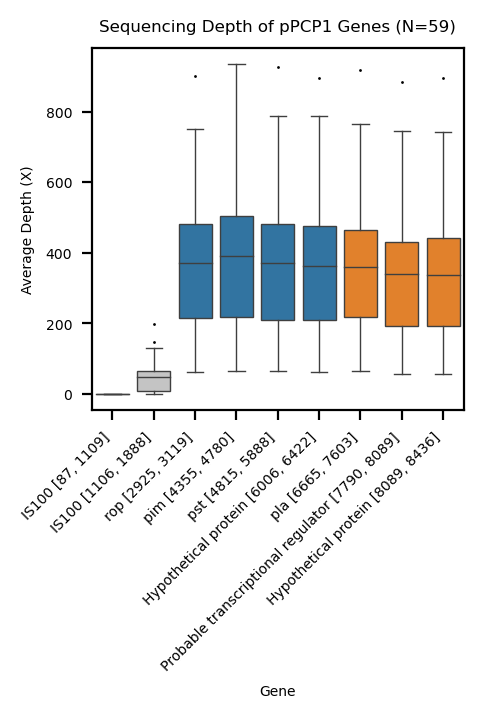

In [36]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

fig, axes = plt.subplots(1,1,figsize=FIGSIZE, dpi=DPI)

ax = axes
df = ppcp1_genes_df[ppcp1_genes_df["gene-YPPCP1.03"] > 10]
data = {
    col:list(df[col]) for col in df.columns
}
df = pd.DataFrame(data)
colors = [gene_labels[gene]["color"] for gene in gene_labels]
sns.boxplot(
    ax=ax,
    data=df,
    flierprops=flierprops,
    palette=colors,
)
xtick_labels = ["{} {}".format(gene_labels[gene]["label"],gene_labels[gene]["coord"])  for gene in gene_labels]
ax.set_xticklabels(xtick_labels)
plt.xticks(rotation=45, ha="right")
ax.set_xlabel("Gene")
ax.set_ylabel("Average Depth (X)")
plt.title("Sequencing Depth of pPCP1 Genes (N={})".format(len(df)))

out_path = os.path.join(out_dir, "ppcp1_gene_depth")
plt.savefig(out_path + ".png", dpi=DPI, bbox_inches = "tight", facecolor="white")
plt.savefig(out_path + ".svg", dpi=DPI, bbox_inches = "tight")

---
# Detect K Cluster

In [37]:
X = np.array(ratio_df["ratio"]).reshape(-1, 1)

### Elbow Method

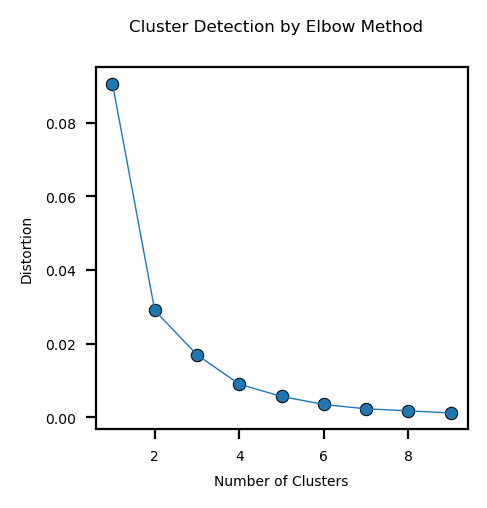

In [38]:
# calculate distortion for a range of number of cluster
distortions = []

iter = 10
for i in range(1, iter):
    km = KMeans(
        n_clusters=i, 
        init='random',
        n_init=10, 
        max_iter=300,
        tol=1e-04, 
        random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

fig, ax = plt.subplots(1,1,figsize=FIGSIZE, dpi=DPI)

sns.lineplot(
    ax=ax,
    x=range(1, iter), 
    y=distortions,
)
sns.scatterplot(
    ax=ax,
    x=range(1, iter), 
    y=distortions,
    s=20,
    ec="black",
    lw=0.5,
)

ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Distortion')
fig.suptitle("Cluster Detection by Elbow Method")

out_path = os.path.join(out_dir, "elbow_{}_{}".format(depleted_gene_label, baseline_gene_label))
plt.savefig(out_path + ".png", bbox_inches = "tight", facecolor="white")
plt.savefig(out_path + ".svg", bbox_inches = "tight")

## Silhoutte Clusters

In [39]:
range_n_clusters = [2, 3, 4, 5, 6]

highest_score = 0
highest_cluster = 0

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    if silhouette_avg > highest_score:
        highest_cluster = n_clusters
        highest_score = silhouette_avg

print(highest_cluster)
# To Plot see: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.5979755876678817
For n_clusters = 3 The average silhouette_score is : 0.5769298600918142
For n_clusters = 4 The average silhouette_score is : 0.5585840611251104
For n_clusters = 5 The average silhouette_score is : 0.5478341928995591
For n_clusters = 6 The average silhouette_score is : 0.5725573113515079
2


---
# Cluster

### Manual Override

In [40]:
highest_cluster = 1

In [41]:
km = KMeans(
    n_clusters=highest_cluster, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

for ratio, cluster, sample in zip(X, y_km, ratio_df.index):
    ratio_df.at[sample, "cluster"] = cluster
    
#display(ratio_df)
cluster_max_ratios = {cluster:0 for cluster in range(0, highest_cluster)}

for cluster in range(0, highest_cluster):
    ratios = [r[0] for r in X[y_km == cluster]]
    cluster_max_ratios[cluster] = max(ratios)

cluster_order = list({cluster:ratio for cluster,ratio in sorted(cluster_max_ratios.items(), key=lambda item: item[1])}.keys())

for rec in ratio_df.iterrows():
    sample = rec[0]
    cluster = rec[1]["cluster"]
    new_cluster = cluster_order.index(cluster)
    ratio_df.at[sample, "cluster"] = new_cluster
    
    
display(ratio_df)

,baseline,depleted,ratio,timetree_num_date,strain,country,cluster
sample,,,,,,,
SAMN01853158,240.716019,242.989349,1.009444,1998.0,154/98 B,Madagascar,0.0
SAMN01853157,298.711365,303.004273,1.014371,1991.0,64/91,Madagascar,0.0
SAMN01853130,288.465546,291.855164,1.011751,1991.0,53/91,Madagascar,0.0
SAMN01853159,199.348236,199.514374,1.000833,1999.0,17/99 B,Madagascar,0.0
SAMN01991273,75.919922,76.784874,1.011393,2001.0,2106,United States of America,0.0
SAMN01991272,75.935753,80.829605,1.064447,1998.0,2055,United States of America,0.0
SAMN01991271,82.640594,83.086266,1.005393,1995.0,2965,United States of America,0.0
SAMN01991270,81.671326,78.703941,0.963667,1991.0,4412,United States of America,0.0
SAMN01991269,90.467415,93.839188,1.037271,1987.0,4954,United States of America,0.0


---
## Plot

No handles with labels found to put in legend.


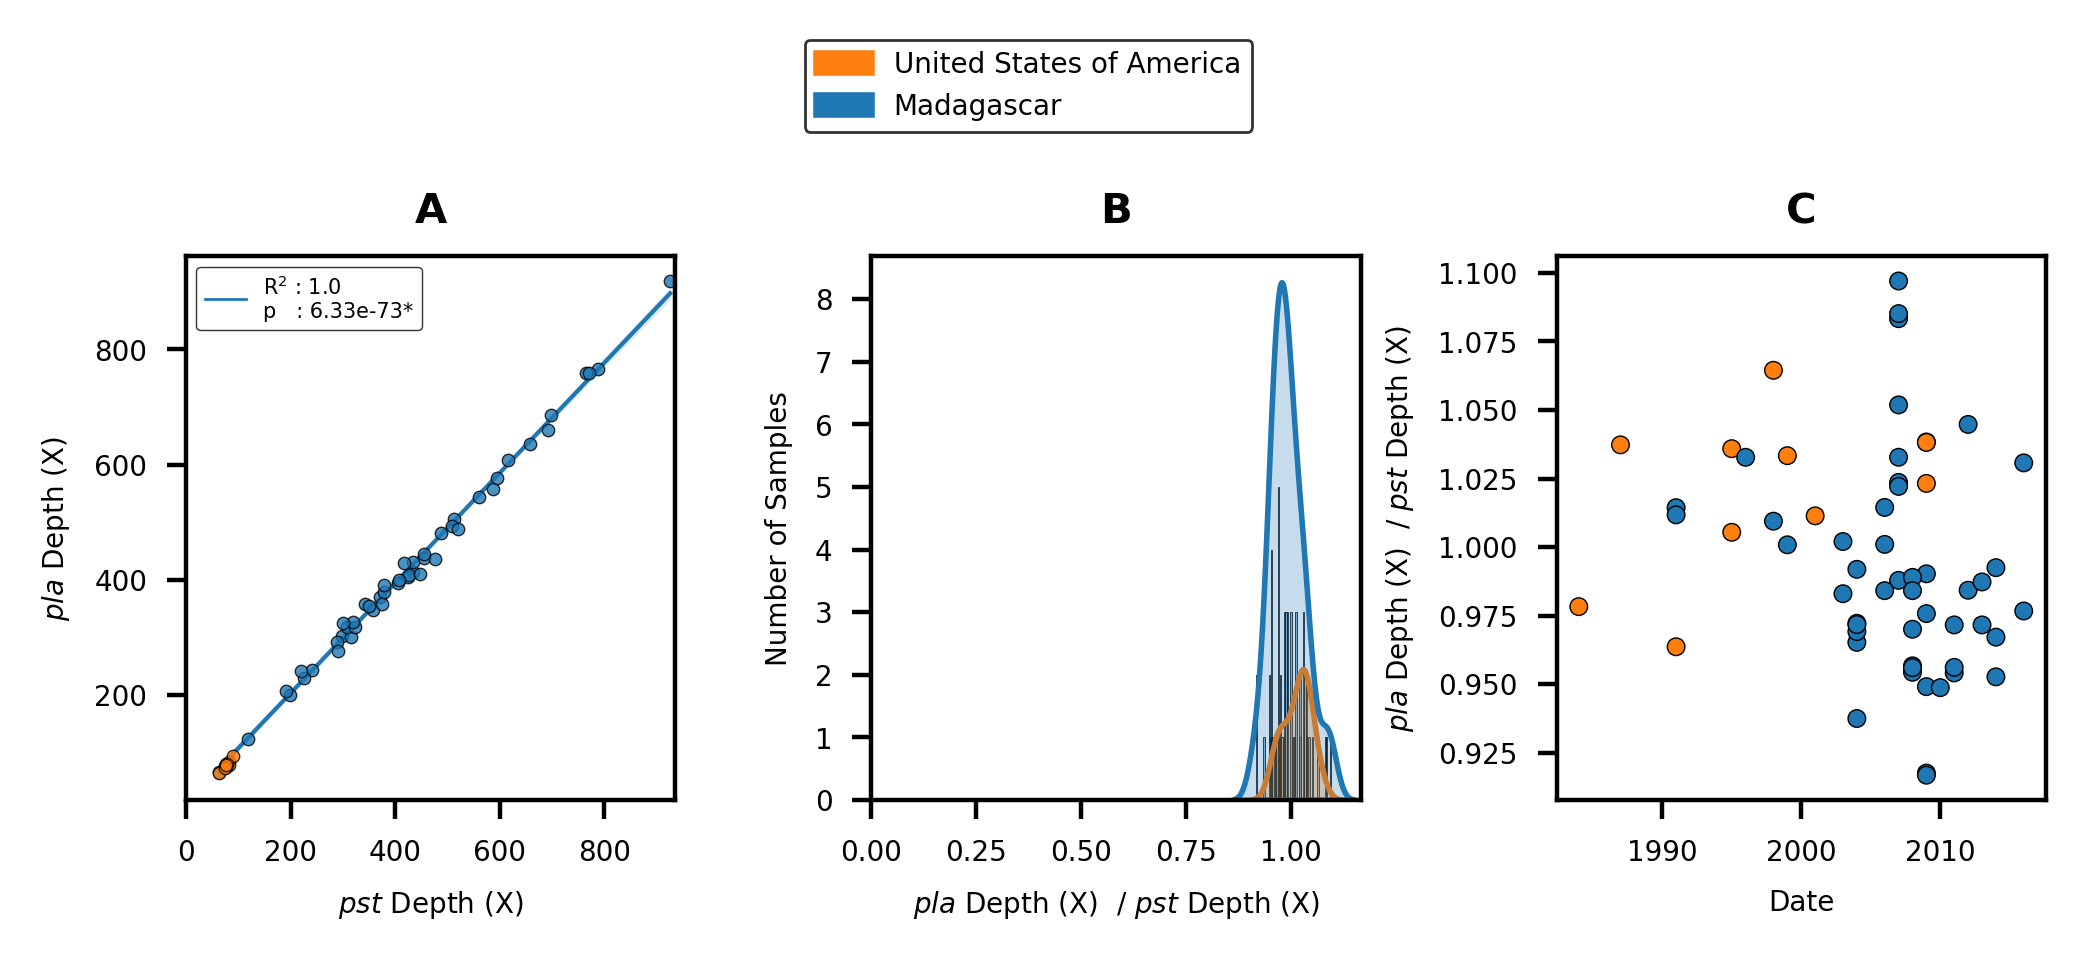

In [65]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [2400, 720]
DPI=400
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

# 2 x2
#fig, axes = plt.subplots(2,2,figsize=FIGSIZE, dpi=DPI)
# 1 x 3
fig, axes = plt.subplots(1,3,figsize=FIGSIZE, dpi=DPI)

fig.subplots_adjust(wspace=0.4, hspace=0.4)

#------------------------------------------------
# Regresion
#ax = axes[0][0]
ax = axes[0]

ax.set_title("A", fontsize=FONTSIZE * 1.5, fontweight="bold")

df = ratio_df[ratio_df["cluster"] == cluster]
#for cluster in range(0, highest_cluster):
for country in set(ratio_df["country"]):
    df = ratio_df[ratio_df["country"] == country]
    sns.regplot(
        ax=ax,
        data=df,
        x="baseline",
        y="depleted", 
        #ci=None,
        scatter_kws={"s": 5, "ec":"black", "lw": 0.25, "zorder":1,},   
        line_kws={"zorder":0, },
    )
    
ax.set_xlabel("$\it{" + "{}".format(baseline_gene_label) + "}$ Depth (X)")
ax.set_ylabel("$\it{" + "{}".format(depleted_gene_label) + "}$ Depth (X)")
ax.set_xlim(0, max(ratio_df["baseline"] + 10))

reg_handles = []
for cluster in range(highest_cluster):
    cluster_df = ratio_df[ratio_df["cluster"] ==cluster]
    x = list(cluster_df["baseline"])
    y = list(cluster_df["depleted"])
    slope, intercept, r_value, p_value, stderr, = scipy.stats.linregress(x,y)
    
    p_sig = ""
    if p_value < 0.05:
        p_sig = "*"
        
    r_squared = r_value * r_value
    r_squared_pretty = str(round(r_squared, 2))
    
    intercept_pretty = "+ " + str(round(intercept, 2)).replace("+","")
    if "-" in str(intercept):
        intercept_pretty = "- " + str(round(intercept, 2)).replace("-","")
        
    reg_handles.append(
        lines.Line2D([0], [0], 
        label = (
            "R$^{2}$ : " + "{}".format(r_squared_pretty)
            #"y = {}x {}".format(round(slope,2),intercept_pretty)
            + "\np   : {:0.2e}{}".format(p_value, p_sig)
        ),
        color=D3_COL_PAL[cluster])
    )

legend = ax.legend(handles=reg_handles, loc=2, fontsize=FONTSIZE * 0.75, edgecolor="black")
legend.get_frame().set_linewidth(0.25)

#------------------------------------------------
# Histogram
#ax = axes[0][1]
ax = axes[1]

ax.set_title("B", fontsize=FONTSIZE * 1.5, fontweight="bold")
sns.histplot(
    ax=ax,
    data=ratio_df,
    x="ratio",
    bins=len(ratio_df),
    #hue="cluster",
    hue="country",
    palette = D3_COL_PAL[0:len(set(ratio_df["country"]))],
    #palette = D3_COL_PAL[0:highest_cluster],
    #alpha=0.75,
    zorder=0,
)
sns.kdeplot(
    ax=ax,
    data=ratio_df,
    x="ratio",
    #hue="cluster",
    hue = "country",
    #palette = D3_COL_PAL[0:highest_cluster],
    palette = D3_COL_PAL[0:len(set(ratio_df["country"]))],    
    #alpha=1.0,
    fill=True,
    zorder=1,
)



ax.set_xlim(0)
ax.set_ylabel("Number of Samples")
ax.set_xlabel(
    "$\it{" 
    + "{}".format(depleted_gene_label)
    + "}$ Depth (X)  / $\it{"
    + "{}".format(baseline_gene_label)
    + "}$ Depth (X)")
ax.legend().remove()

#------------------------------------------------
# Boxplot

"""
ax = axes[1][0]
ax.set_title("C", fontsize=FONTSIZE * 1.5, fontweight="bold")

sns.boxplot(
    ax=ax,
    data=ratio_df,
    x="cluster",
    y="ratio",
    flierprops=flierprops,
)
ax.set_xlabel("Cluster")
ax.set_xticklabels(["Depleted", "Normal"])
ax.set_ylabel(
    "$\it{" 
    + "{}".format(depleted_gene_label)
    + "}$ Depth (X)  / $\it{"
    + "{}".format(baseline_gene_label)
    + "}$ Depth (X)")
"""

# --------------------------------------
# TIMELINE
#ax = axes[1][1]
ax = axes[2]
ax.set_title("C", fontsize=FONTSIZE * 1.5, fontweight="bold")
sns.scatterplot(
    ax=ax, 
    data=ratio_df, 
    x="timetree_num_date", 
    y="ratio",
    s=10,
    ec="black",
    #palette = D3_COL_PAL[0:highest_cluster],
    #hue="cluster",
    hue="country",
    palette = D3_COL_PAL[0:len(set(ratio_df["country"]))],     
)
ax.legend().remove()

#------------------------------------------------
# Date Confidences
"""for sample in ratio_df.index:
    conf = [float(c) for c in metadata_df["timetree_num_date_confidence"][sample].strip("[]").split(",")]
    ratio = ratio_df["ratio"][sample]
    cluster = int(ratio_df["cluster"][sample])
    color = D3_COL_PAL[cluster]
    ax.add_patch(
        patches.Rectangle(
            (conf[0], ratio), conf[1] - conf[0], 0.02, linewidth=0, facecolor=color, alpha=0.20, zorder=0))"""


#ax.set_xlim(1150,1850)
ax.set_xlabel("Date")
ax.set_ylabel(
    "$\it{" 
    + "{}".format(depleted_gene_label)
    + "}$ Depth (X)  / $\it{"
    + "{}".format(baseline_gene_label)
    + "}$ Depth (X)")

#------------------------------------------------
# Legend
#normal_patch = patches.Patch(color=D3_COL_PAL[1], label='Normal $\it{pla}$')
normal_patch = patches.Patch(color=D3_COL_PAL[1], label='United States of America')
#low_patch = patches.Patch(color=D3_COL_PAL[0], label='Depleted $\it{pla}$')
low_patch = patches.Patch(color=D3_COL_PAL[0], label='Madagascar')
#legend = fig.legend(handles=[normal_patch, low_patch], bbox_to_anchor=(0.6,0.98), edgecolor="black")
legend = fig.legend(handles=[normal_patch, low_patch], bbox_to_anchor=(0.575,1.2), edgecolor="black")
legend.get_frame().set_linewidth(0.5)

"""fig.suptitle(
    "Relative depletion of the plasminogen activator ($\it{pla}$) virulence factor", 
    x=0.5, 
    y=1.3, 
    fontsize=FONTSIZE * 2,
)"""

out_path = os.path.join(out_dir, "depletion_{}".format(depleted_gene_label))
plt.savefig(out_path + ".png", bbox_inches = "tight", facecolor="white")
plt.savefig(out_path + ".svg", bbox_inches = "tight")

## Add Depletion Statistics to Metadata

In [ ]:
metadata_df["baseline_{}".format(baseline_gene_label)] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["depleted_{}".format(depleted_gene_label)] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["ratio_{}_{}".format(depleted_gene_label, baseline_gene_label)] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["cluster_{}_{}".format(depleted_gene_label, baseline_gene_label)] = [NO_DATA_CHAR] * len(metadata_df)

# Including filter
#for rec in ratio_df.iterrows():
# Excluding filtering
for sample in ratio_orig_df.index:
    metadata_df.at[sample, "baseline_{}".format(baseline_gene_label)] = ratio_orig_df["baseline"][sample]
    metadata_df.at[sample, "depleted_{}".format(depleted_gene_label)] = ratio_orig_df["depleted"][sample]
    metadata_df.at[sample, "ratio_{}_{}".format(depleted_gene_label, baseline_gene_label)] = ratio_orig_df["ratio"][sample]
    if sample in ratio_df.index:
        metadata_df.at[sample, "cluster_{}_{}".format(depleted_gene_label, baseline_gene_label)] = ratio_df["cluster"][sample]
    
display(metadata_df)

## Draw Tree

In [ ]:
for c in tree.get_terminals():
    sample = c.name
    cluster = metadata_df["cluster_{}_{}".format(depleted_gene_label, baseline_gene_label)][sample]
    if cluster == NO_DATA_CHAR:
        color = "#c4c4c4"
    else:
        color = D3_COL_PAL[int(cluster)]
    c.color = color

# ---------------------------------------
# PLOT SETUP
TARGET_RES = [960, 960]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=4
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)

Phylo.draw(
    tree, 
    axes=ax, 
    show_confidence=False, 
    label_func = lambda x: metadata_df["country_date_strain"][x.name] if x.is_terminal() else "", 
    do_show=False
)

ax.axis("off")
#ax.set_ylabel("")
#ax.set_yticklabels([])
#ax.set_xlabel("Years")

#------------------------------------------------
# Legend
normal_patch = patches.Patch(color=D3_COL_PAL[1], label='Normal $\it{pla}$')
low_patch = patches.Patch(color=D3_COL_PAL[0], label='Depleted $\it{pla}$')
unknown_patch = patches.Patch(color="#c4c4c4", label='Unknown $\it{pla}$')
legend = fig.legend(handles=[normal_patch, low_patch, unknown_patch], loc=6, edgecolor="black")
legend.get_frame().set_linewidth(0.5)

out_path = os.path.join(out_dir, "depletion_tree_{}".format(depleted_gene_label))
plt.savefig(out_path + ".png", bbox_inches = "tight", facecolor="white", dpi=DPI)
plt.savefig(out_path + ".svg", bbox_inches = "tight")

# Export

## Metadata

In [ ]:
out_path_metadata = os.path.join(out_dir, "metadata.tsv")
metadata_df.to_csv(out_path_metadata, sep="\t", index=True)

## Timetree

In [ ]:
out_tree = copy.deepcopy(tree)

metadata_to_comment(out_tree, metadata_df)    
out_path_tree_nex = os.path.join(out_dir, "all.timetree.nex")
Phylo.write(out_tree, out_path_tree_nex, "nexus")

## Prior Distribution

In [ ]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=4
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

priors = {
    "Denmark": {"mu": 1330, "range" : 230}, 
    "Rostov2033": {"mu": 1767.5, "range": 2.75 },
    "Azov38": {"mu":2021-471.0, "range": 75.0},
    "CHE1" : {"mu": 2021-371.0, "range" :75.0}, 
    "BED" : {"mu": 2021-423.5, "range" : 18.75}
}

for prior in priors:
          
    fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)


    mu = priors[prior]["mu"]
    date_range = priors[prior]["range"]
    sigma = date_range / 2
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = scipy.stats.norm.pdf(x, mu, sigma)

    ax.fill_between(x, y, alpha=0.25)

    sns.lineplot(ax=ax, x=x, y=y)
    #ax.plot(x, scipy.stats.norm.pdf(x, mu, sigma))
    ax.set_title("{} Collection Date Prior".format(prior), fontsize=FONTSIZE * 1.5, y=1.1)
    ax.set_xlabel("Date", fontsize=FONTSIZE * 1.5)
    ax.set_ylabel("Density", fontsize=FONTSIZE * 1.5)

    ax.axvline(x=mu, color="black", label="Mean Site Date")
    ax.axvline(x=mu - date_range, color="black", linestyle="--", label="Site Date Range")
    ax.axvline(x=mu + date_range, color="black", linestyle="--",)
    ax.legend(bbox_to_anchor=(0.30,1), edgecolor="black").get_frame().set_linewidth(0.5)


#out_path = os.path.join(out_dir, "prior_denmark")
#plt.savefig(out_path + ".png", bbox_inches = "tight", facecolor="white")
#plt.savefig(out_path + ".svg", bbox_inches = "tight")